Predicted price: [245.69780371]


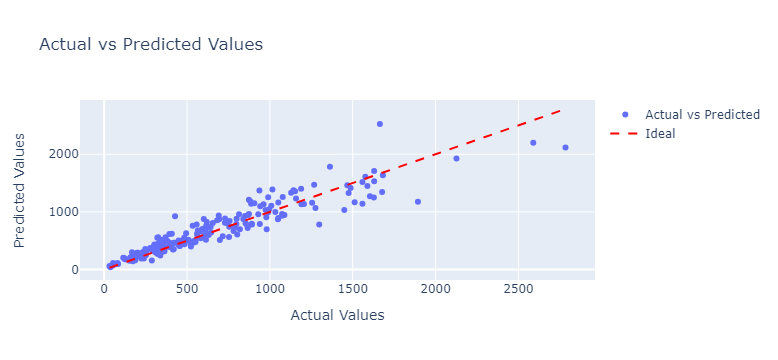

In [23]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
import pickle

data = pd.read_csv("dynamic_pricing.csv")


# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)


# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    #Handle missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

data["Vehicle_Type"] = data["Vehicle_Type"].map({"Premium": 1,
                                                 "Economy": 0})

#splitting data

x = np.array(data[["Number_of_Riders", 
                   "Number_of_Drivers", 
                   "Vehicle_Type", 
                   "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Training a random forest regression model

model = RandomForestRegressor()
model.fit(x_train, y_train)

def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    input_data = np.array([[number_of_riders, 
                            number_of_drivers, 
                            vehicle_type_numeric, 
                            Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
Expected_Ride_Duration = 30
predicted_price = predict_price(user_number_of_riders,
                                user_number_of_drivers,
                                user_vehicle_type,
                                Expected_Ride_Duration)
print("Predicted price:", predicted_price)

# Predict on the test set
y_pred = model.predict(x_test)

# Create a scatter plot with actual vs predicted values
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

# Add a line representing the ideal case
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
)

fig.show()

pickle.dump(model,open('model.pk1','wb'))
model=pickle.load(open('model.pk1','rb'))

